In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import keras
from keras import Model, layers
from keras.models import load_model, model_from_json
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_zip = '/content/drive/MyDrive/Topicos em IA'
work_dir = '/content/sample_data'

In [ ]:
import zipfile

with zipfile.ZipFile(f'{dir_zip}/dogs-vs-cats.zip', 'r') as zip_ref:
    zip_ref.extractall(f'{work_dir}/raw')

In [ ]:
train_generator = tf.keras.utils.image_dataset_from_directory(
  f'{work_dir}/raw/Data/train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(128, 128),
  batch_size=32)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


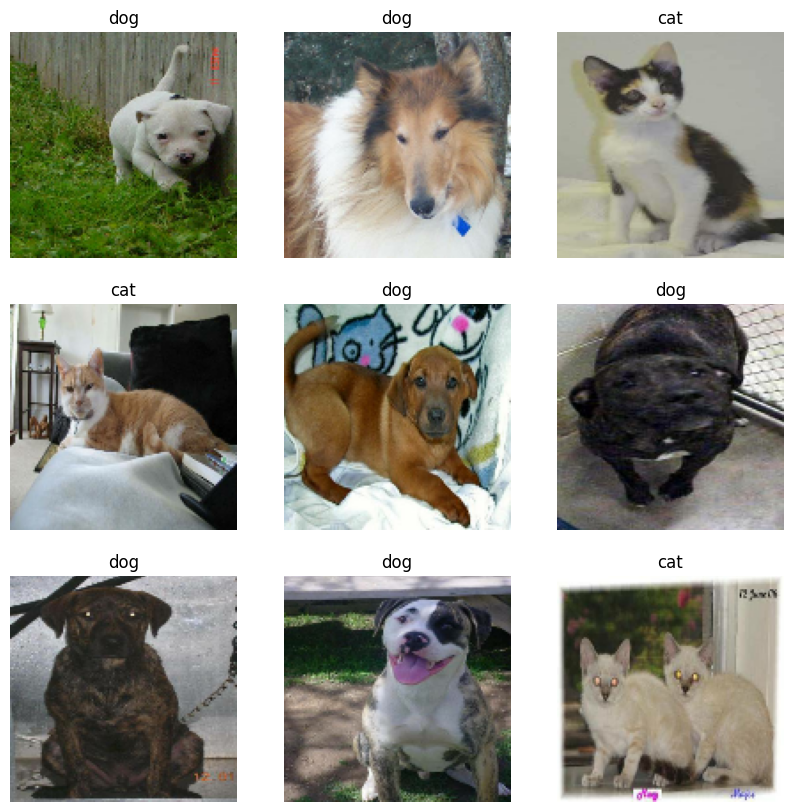

In [ ]:
class_names = train_generator.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_generator.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
validation_generator = tf.keras.utils.image_dataset_from_directory(
  f'{work_dir}/raw/Data/train',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(128, 128),
  batch_size=32)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
test_generator = tf.keras.utils.image_dataset_from_directory(
  f'{work_dir}/raw/Data/test',
  seed=42,
  image_size=(128, 128),
  batch_size=32)

Found 12500 files belonging to 1 classes.


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
base_model = keras.applications.InceptionV3(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(128, 128, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.inception_v3.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
initial_epochs = 10

history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=validation_generator)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 60ms/step - accuracy: 0.8049 - loss: 0.4909 - val_accuracy: 0.9292 - val_loss: 0.1684
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 69s 47ms/step - accuracy: 0.8718 - loss: 0.3160 - val_accuracy: 0.9448 - val_loss: 0.1494
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.8791 - loss: 0.3033 - val_accuracy: 0.9400 - val_loss: 0.1528
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.8798 - loss: 0.2926 - val_accuracy: 0.9340 - val_loss: 0.1607
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.8766 - loss: 0.3047 - val_accuracy: 0.9388 - val_loss: 0.1621
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.8758 - loss: 0.3027 - val_accuracy: 0.9404 - val_loss: 0.1691
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 47ms/step - accuracy: 0.8824 - loss: 0.2825 - val_accuracy: 0.9446 - val_loss: 0.1571
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.8788 - loss: 0.2830 - 

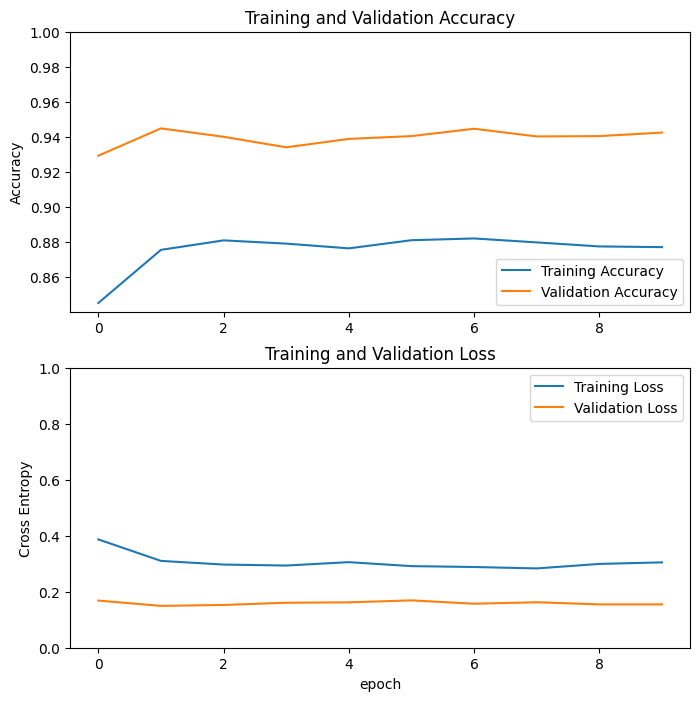

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 250

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  311


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator)

Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 68s 83ms/step - accuracy: 0.8332 - loss: 0.3481 - val_accuracy: 0.9488 - val_loss: 0.1296
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 73s 72ms/step - accuracy: 0.8904 - loss: 0.2376 - val_accuracy: 0.9528 - val_loss: 0.1156
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 79ms/step - accuracy: 0.9013 - loss: 0.2196 - val_accuracy: 0.9560 - val_loss: 0.1107
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 76s 70ms/step - accuracy: 0.9072 - loss: 0.2050 - val_accuracy: 0.9578 - val_loss: 0.1069
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 70ms/step - accuracy: 0.9125 - loss: 0.1962 - val_accuracy: 0.9576 - val_loss: 0.1047
Epoch 15/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 70ms/step - accuracy: 0.9167 - loss: 0.1828 - val_accuracy: 0.9580 - val_loss: 0.1025
Epoch 16/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 74ms/step - accuracy: 0.9213 - loss: 0.1753 - val_accuracy: 0.9578 - val_loss: 0.0998
Epoch 17/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 71ms/step - accuracy: 0.9213 - loss: 0

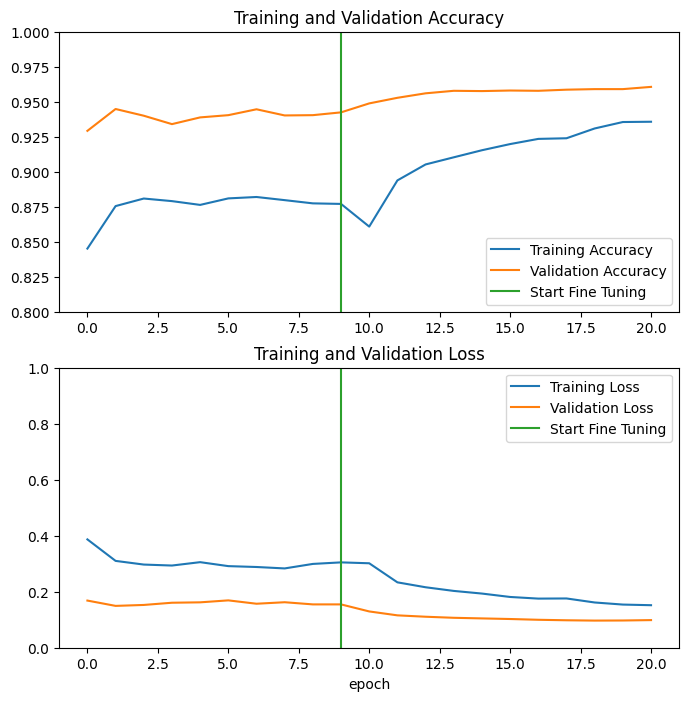

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
feature, labels = test_generator.as_numpy_iterator().next()

In [ ]:
pred_probs = model.predict(feature)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


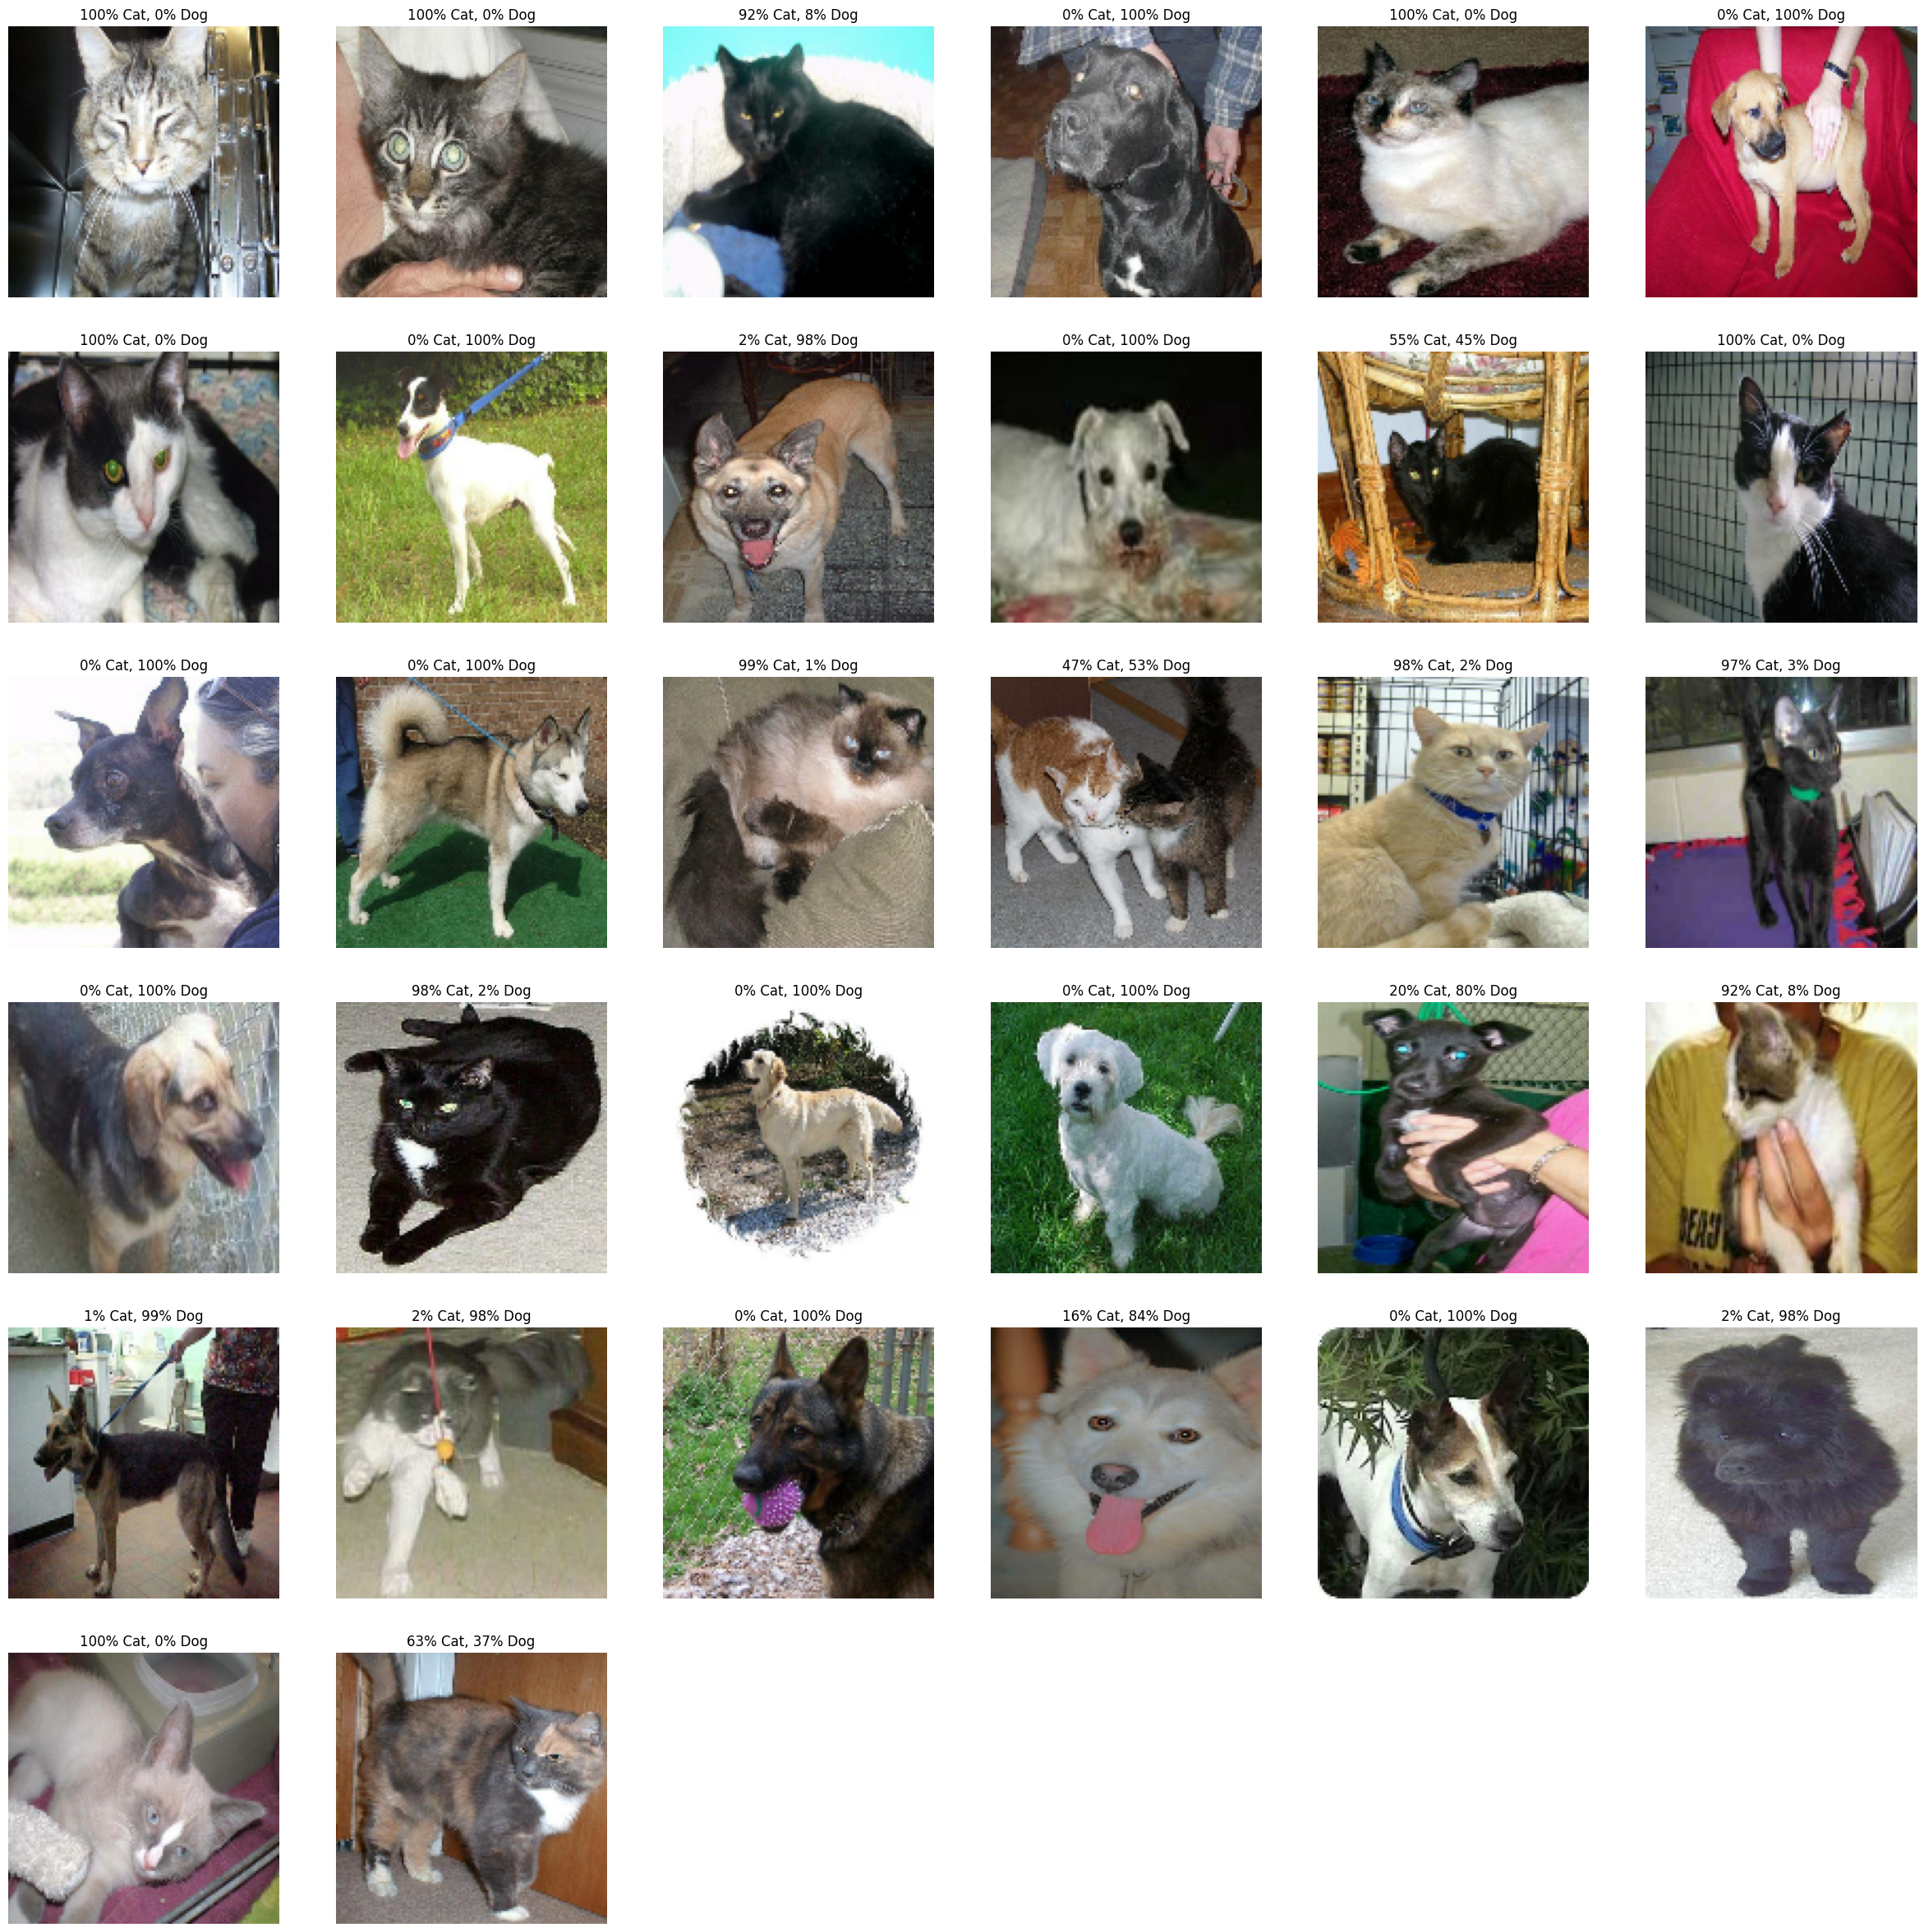

In [ ]:
import math

plt.figure(figsize = (30, 30))
subplot_num = math.ceil(math.sqrt(len(feature)))

# Converter logits em probabilidades
pred_probs = tf.nn.sigmoid(model.predict(feature)).numpy()

for i in range(len(feature)):
    plt.subplot(subplot_num, subplot_num, i + 1)
    plt.imshow(feature[i].astype('uint8'))
    # Corrigido para classificação binária
    plt.title("{:.0f}% Cat, {:.0f}% Dog".format(100 * (1 - pred_probs[i][0]),
                                                100 * pred_probs[i][0]))
    plt.axis("off")
